In [3]:
import os
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
# Torch Vision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
# Transformers
from transformers import ViTImageProcessor, ViTForImageClassification
# Utils
from tqdm import tqdm
import numpy as np
# Train Test Evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


### Preparing The Models

In [4]:
g_vit_patch = 'google/vit-base-patch16-224'
base_path = '/kaggle/input/ecg-image-data' # For training Data
base_output_path = '/kaggle/working' # For Storing weights and all
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 1
NUM_WORKERS = 2

In [5]:
# CNN Model with Explicit Device Handling
class CNNModel(nn.Module):
    def __init__(self, num_classes, device, cnn_model=models.resnet18(weights='ResNet18_Weights.DEFAULT')):
        super(CNNModel, self).__init__()
        self.cnn = cnn_model
        num_ftrs = self.cnn.fc.in_features
        self.cnn.fc = nn.Linear(num_ftrs, num_classes)
        self.device = device

    def forward(self, x):
        # Ensure input is on the correct device
        x = x.to(self.device)
        return self.cnn(x)

# ViT Model with Explicit Device Handling
class ViTModel(nn.Module):
    def __init__(self, num_classes, device, vit_model_name=g_vit_patch):
        super(ViTModel, self).__init__()
        self.feature_extractor = ViTImageProcessor.from_pretrained(vit_model_name,do_rescale=False)
        self.model = ViTForImageClassification.from_pretrained(
            vit_model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True,
        )
        self.device = device

    def forward(self, x):
        # Ensure input is on the correct device
        x = x.to(self.device)  # Move to the specified device
        # Prepare inputs for ViT model
        feature_input = self.feature_extractor(x, return_tensors="pt").to(self.device)
        logits = self.model(**feature_input).logits
        return logits

# Ensemble Model with Explicit Device Handling
class EnsembleModel(nn.Module):
    def __init__(self, num_classes, cnn_model, vit_model, device):
        super(EnsembleModel, self).__init__()
        self.cnn_model = cnn_model
        self.vit_model = vit_model
        self.fc = nn.Linear(num_classes * 2, num_classes)  # Final linear layer
        self.device = device

    def forward(self, x):
        # Ensure input is on the correct device
        x = x.to(self.device)
        
        # Forward through CNN and ViT
        cnn_output = self.cnn_model(x)  # CNN output
        vit_output = self.vit_model(x)  # ViT output
        
        # Combine outputs
        combined_output = torch.cat((cnn_output, vit_output), dim=1)  # Concatenate
        
        # Final linear output
        return self.fc(combined_output)
    
    def eval(self, *args, **kwargs):
        super().eval(*args, **kwargs)  # Call eval() on the parent class
        
        # Call eval() on the underlying models
        self.cnn_model.eval(*args, **kwargs)
        self.vit_model.eval(*args, **kwargs)
        
    def train(self, *args, **kwargs):
        super().train( *args, **kwargs)  # Call train() on the parent class
        
        # Call train() on the underlying models
        self.cnn_model.train( *args, **kwargs)
        self.vit_model.train( *args, **kwargs)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.2MB/s]


### Data Preparation

In [6]:
def preprocess(base_path: str, device: torch.device):
    # Your transformations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    print("Loading Datasets...")
    # Load datasets
    train_dataset = datasets.ImageFolder(
        root=os.path.join(base_path, "train"),
        transform=train_transform
    )
    
    test_dataset = datasets.ImageFolder(
        root=os.path.join(base_path, "test"),
        transform=test_transform
    )
    
    print("Balancing Training Datasets...")

    # Assuming you have a dataset 'dataset' with labels 'labels'
    # Calculate class counts
    labels = torch.tensor(train_dataset.targets)
    train_class_counts = torch.bincount(labels)
    train_desired_count = torch.min(train_class_counts)

    # Calculate weights for each sample based on class counts and desired count
    weights = train_desired_count / train_class_counts.float()  # Adjusted weights based on desired count
    
    sample_weights = weights[labels]

    # Create WeightedRandomSampler with the calculated weights
    num_samples = int(train_desired_count * len(train_class_counts))
    train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)
    
    print("Preparing the loaders...")
    # Load data using DataLoader with the specified sampler
    train_loader = DataLoader(train_dataset, num_workers=4, batch_size=75, sampler=train_sampler)
    test_loader = DataLoader(test_dataset, num_workers=4, batch_size=75, shuffle=True)
    
    print(f"{train_class_counts=} {train_desired_count=}")
    print("All Done...")
    
    return train_dataset, test_dataset, train_loader, test_loader

In [7]:
# Define the folder where your ECG image data is stored
data_folder = os.path.join(base_path, 'ECG_Image_data')

train_dataset, test_dataset, train_loader, test_loader = preprocess(data_folder, device)

Loading Datasets...
Balancing Training Datasets...
Preparing the loaders...
train_class_counts=tensor([  642,  8405, 75709,  6431,  2223,  5789]) train_desired_count=tensor(642)
All Done...


In [8]:
def get_class_counts(train_loader):
    class_counts = torch.zeros(len(train_loader.dataset.classes), dtype=torch.int)
    for _, labels in train_loader:
        class_counts += torch.bincount(labels, minlength=len(train_loader.dataset.classes))
    return class_counts.numpy()

train_class_counts = get_class_counts(train_loader)
test_class_counts = get_class_counts(test_loader)
print("Samples per class in train_loader:",train_class_counts)
print("Samples per class in test_loader:",test_class_counts)

Samples per class in train_loader: [652 661 656 644 634 605]
Samples per class in test_loader: [  161  2101 18926  1608   556  1447]


In [9]:
# Data Quality Checker
def check_sample_data(data_loader, expected_shape, num_samples=5):
    # Get a few samples from the DataLoader
    samples_checked = 0
    for inputs, labels in data_loader:
        if samples_checked >= num_samples:
            break

        # Check dimensions
        if inputs.shape[1:] != expected_shape:
            raise ValueError(f"Unexpected input shape. Expected {expected_shape}, but got {inputs.shape[1:]}")
        
        # Check data type
        if inputs.dtype != torch.float32:
            raise ValueError(f"Unexpected data type. Expected torch.float32, but got {inputs.dtype}")
        
        # Check normalization (values within range)
        if inputs.min() < -1.0 or inputs.max() > 1.0:
            raise ValueError(f"Input data out of expected range. Values should be between -1 and 1.")

        # Check if labels are within the expected range
        if torch.min(labels) < 0 or torch.max(labels) >= len(data_loader.dataset.classes):
            raise ValueError(f"Unexpected label range. Labels should be between 0 and {len(data_loader.dataset.classes) - 1}")

        samples_checked += 1

    print(f"Data check completed. {num_samples} samples checked successfully.")


In [10]:
expected_shape = (3, 224, 224)
print("Checking training data...")
check_sample_data(train_loader, expected_shape)

print("Checking test data...")
check_sample_data(test_loader, expected_shape)

Checking training data...
Data check completed. 5 samples checked successfully.
Checking test data...
Data check completed. 5 samples checked successfully.



### Training Ensemble Model

In [11]:
class TrainEvaluator:
    running_loss:float
    correct_preds:int
    total_preds:int
    total_data_count:int
    curr_epoch: int
    total_epochs: int
    
    def __init__(self,total_data_count:int, curr_epoch:int, total_epochs:int):
        self.running_loss = 0.0
        self.correct_preds = 0
        self.total_preds = 0
        self.total_data_count = total_data_count
        self.curr_epoch = curr_epoch
        self.total_epochs = total_epochs
    
    
    def update_loss(self, loss: float):
        self.running_loss += loss
        return self
    
    
    def update_preds(self, correct_preds, total_preds):
        self.correct_preds += correct_preds
        self.total_preds += total_preds
        return self
    
    
    def metrics(self):
        epoch_loss = self.running_loss / self.total_data_count
        epoch_accuracy =self.correct_preds / self.total_preds * 100
        
        print(f'Epoch [{self.curr_epoch + 1}/{self.total_epochs}], '
              f'Training Loss: {epoch_loss:.4f}, '
              f'Training Accuracy: {epoch_accuracy:.2f}%')

In [12]:
# Initialize the models
num_classes = 6  # Number of classes in your dataset
cnn_model = CNNModel(num_classes,device)
vit_model = ViTModel(num_classes,device, g_vit_patch)
ensemble_model = EnsembleModel(num_classes, cnn_model, vit_model, device)

# Move models to the GPU if available
cnn_model = cnn_model.to(device)
vit_model = vit_model.to(device)
ensemble_model = ensemble_model.to(device)

# Define loss function and optimizer on the same device
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)

total_train = len(train_loader)
print(f"{num_epochs=} {total_train=}")
with tqdm(total=num_epochs * total_train) as pbar:
    for epoch in tqdm(range(num_epochs), position=0, leave=True):
        ensemble_model.train()  # Set model to training mode
        evaluator = TrainEvaluator(total_train, epoch, num_epochs)
        # Iterate through training data
        for inputs, labels in tqdm(train_loader,total=total_train, position=0, leave=True):
            inputs,labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = ensemble_model(inputs)  # Forward pass

            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            pbar.update(1)
            
            _, predicted = outputs.max(1)
            evaluator.update_loss(
                loss.item()
            ).update_preds(
                (predicted == labels).sum().item(),labels.size(0)
            )
        evaluator.metrics()

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


num_epochs=1 total_train=52


100%|██████████| 52/52 [02:35<00:00,  3.00s/it]

Epoch [1/1], Training Loss: 0.1124, Training Accuracy: 96.50%


In [13]:
# Save the trained models to disk
def save_models(cnn_model, vit_model, ensemble_model, base_path:str):
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    # Save models to disk
    torch.save(cnn_model.state_dict(), os.path.join(base_path, "cnn_model"))
    torch.save(vit_model.state_dict(), os.path.join(base_path, "vit_model"))
    torch.save(ensemble_model.state_dict(), os.path.join(base_path, "ensemble_model"))
    print("Models saved successfully!")
    


# Load the trained models from disk
def load_models(device:torch.device, base_path:str):
    # Initialize models
    num_classes = 6
    cnn_model = CNNModel(num_classes,device)
    vit_model = ViTModel(num_classes,device)
    ensemble_model = EnsembleModel(num_classes, cnn_model, vit_model, device)

    # Load model weights
    cnn_model.load_state_dict(torch.load(os.path.join(base_path, "cnn_model")))
    vit_model.load_state_dict(torch.load(os.path.join(base_path, "vit_model")))
    ensemble_model.load_state_dict(torch.load(os.path.join(base_path, "ensemble_model")))

    # Move models to the GPU if available
    cnn_model = cnn_model.to(device)
    vit_model = vit_model.to(device)
    ensemble_model = ensemble_model.to(device)

    return cnn_model, vit_model, ensemble_model

In [14]:
# export models
trained_model_path = os.path.join(base_output_path, "model_weights")
save_models(cnn_model, vit_model, ensemble_model, trained_model_path)

Models saved successfully!


### Evaluation

In [15]:
# Evaluate the model to get accuracy, F1 score, and ROC AUC
ensemble_model.eval()  # Set to evaluation mode


In [16]:
# Initialize lists to store predictions and probabilities
y_true = []
y_pred = []
y_proba = []

total_test = len(test_loader)

# Collect predictions and ground truth
with torch.no_grad():        
    # Iterate through test data
    for inputs, labels in tqdm(test_loader, total=total_test):
        inputs,labels = inputs.to(device), labels.to(device)
        outputs = ensemble_model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        probs = torch.softmax(outputs, dim=1)
        
        # Extend lists with values from current batch
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_proba.extend(probs.cpu().numpy())  # Get probabilities for ROC AUC

# Reshape y_proba into a 2D array
y_proba = np.array(y_proba)

100%|██████████| 331/331 [07:32<00:00,  1.37s/it]


In [17]:
y_true == y_pred

True

In [18]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate F1 score (weighted to account for class imbalance)
f1 = f1_score(y_true, y_pred, average='weighted')

Accuracy: 1.0
F1 Score: 1.0


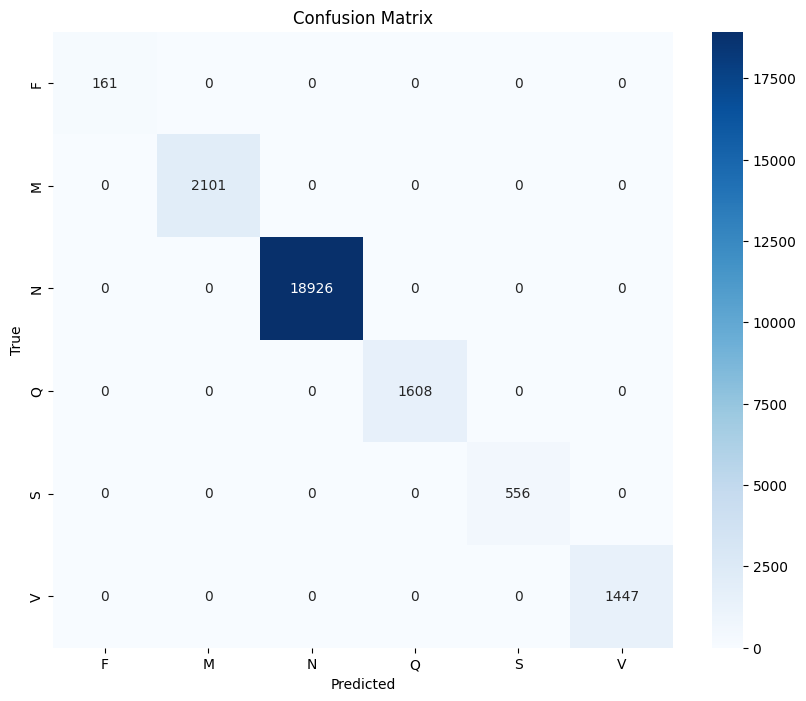

In [19]:
# Print accuracy and F1 score
print("Accuracy:", accuracy)
print("F1 Score:", f1)

# Confusion matrix for additional visualization
confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()